In [1]:
import numpy as np
import os
from sklearn.metrics import confusion_matrix
import seaborn as sn; sn.set(font_scale=1.4)
from sklearn.utils import shuffle           
import matplotlib.pyplot as plt             
import cv2                                 
import tensorflow as tf                
from tqdm import tqdm

In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
from tensorflow.python.client import device_lib

device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 1871282396731640740,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 6579684390
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 14622936420861860920
 physical_device_desc: "device: 0, name: GeForce GTX 1080, pci bus id: 0000:01:00.0, compute capability: 6.1"]

In [4]:
tf.test.gpu_device_name()


'/device:GPU:0'

In [5]:
class_names = ['mountain', 'street', 'glacier', 'buildings', 'sea', 'forest']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)

IMAGE_SIZE = (150, 150)

In [6]:
def load_data():
    """
        Load the data:
            - 14,034 images to train the network.
            - 3,000 images to evaluate how accurately the network learned to classify images.
    """
    
    datasets = ['input/seg_train/seg_train', 'input/seg_test/seg_test']
    output = []
    
    # Iterate through training and test sets
    for dataset in datasets:
        
        images = []
        labels = []
        
        print("Loading {}".format(dataset))
        
        # Iterate through each folder corresponding to a category
        for folder in os.listdir(dataset):
            label = class_names_label[folder]
            
            # Iterate through each image in our folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                
                # Get the path name of the image
                img_path = os.path.join(os.path.join(dataset, folder), file)
                
                # Open and resize the img
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE) 
                
                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)
                
        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')   
        
        output.append((images, labels))

    return output

In [7]:
(train_images, train_labels), (test_images, test_labels) = load_data()

 11%|████████▎                                                                    | 236/2191 [00:00<00:00, 2119.60it/s]

Loading input/seg_train/seg_train


100%|██████████████████████████████████████████████████████████████████████████████| 437/437 [00:00<00:00, 2209.36it/s]

Loading input/seg_test/seg_test



100%|██████████████████████████████████████████████████████████████████████████████| 501/501 [00:00<00:00, 2182.87it/s]


In [8]:
train_images, train_labels = shuffle(train_images, train_labels, random_state=25)

In [9]:
n_train = train_labels.shape[0]
n_test = test_labels.shape[0]

print ("Number of training examples: {}".format(n_train))
print ("Number of testing examples: {}".format(n_test))
print ("Each image is of size: {}".format(IMAGE_SIZE))

Number of training examples: 14034
Number of testing examples: 3000
Each image is of size: (150, 150)


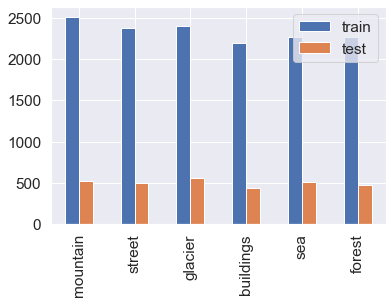

In [10]:
import pandas as pd

_, train_counts = np.unique(train_labels, return_counts=True)
_, test_counts = np.unique(test_labels, return_counts=True)
pd.DataFrame({'train': train_counts,
                    'test': test_counts}, 
             index=class_names
            ).plot.bar()
plt.show()

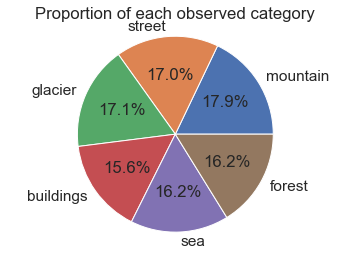

In [11]:
plt.pie(train_counts,
        explode=(0, 0, 0, 0, 0, 0) , 
        labels=class_names,
        autopct='%1.1f%%')
plt.axis('equal')
plt.title('Proportion of each observed category')
plt.show()

In [12]:
train_images = train_images / 255.0 
test_images = test_images / 255.0

In [13]:
def display_random_image(class_names, images, labels):
    """
        Display a random image from the images array and its correspond label from the labels array.
    """
    
    index = np.random.randint(images.shape[0])
    plt.figure()
    plt.imshow(images[index])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Image #{} : '.format(index) + class_names[labels[index]])
    plt.show()

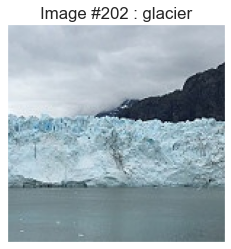

In [14]:
display_random_image(class_names, train_images, train_labels)

In [15]:
def display_examples(class_names, images, labels):
    """
        Display 25 images from the images array with its corresponding labels
    """
    
    fig = plt.figure(figsize=(10,10))
    fig.suptitle("Some examples of images of the dataset", fontsize=16)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[i]])
    plt.show()

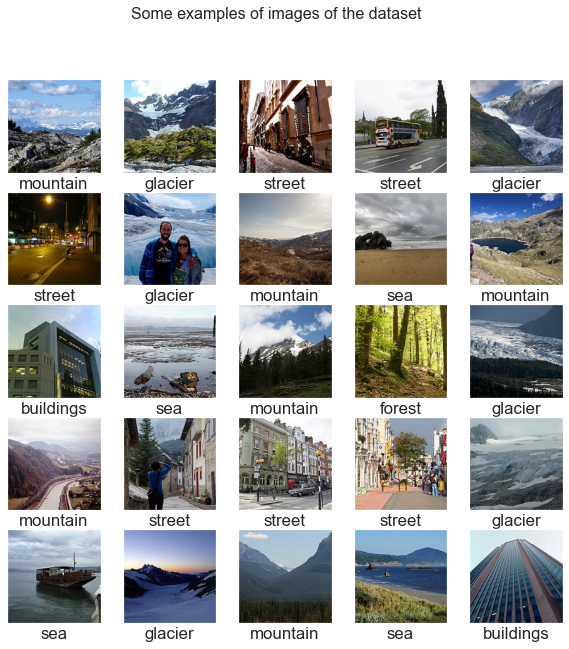

In [16]:
display_examples(class_names, train_images, train_labels)


In [17]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 3)), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
])

In [18]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [19]:
history = model.fit(train_images, train_labels, batch_size=128, epochs=20, validation_split = 0.2)

Epoch 1/20
88/88 [==============================] - 14s 126ms/step - loss: 1.9384 - accuracy: 0.3683 - val_loss: 0.9509 - val_accuracy: 0.6395
Epoch 2/20
88/88 [==============================] - 10s 114ms/step - loss: 0.8491 - accuracy: 0.6822 - val_loss: 0.7628 - val_accuracy: 0.7196
Epoch 3/20
88/88 [==============================] - 10s 114ms/step - loss: 0.6295 - accuracy: 0.7701 - val_loss: 0.7517 - val_accuracy: 0.7207
Epoch 4/20
88/88 [==============================] - 10s 114ms/step - loss: 0.5220 - accuracy: 0.8158 - val_loss: 0.7604 - val_accuracy: 0.7292
Epoch 5/20
88/88 [==============================] - 10s 115ms/step - loss: 0.4006 - accuracy: 0.8599 - val_loss: 0.7498 - val_accuracy: 0.7488
Epoch 6/20
88/88 [==============================] - 10s 116ms/step - loss: 0.2794 - accuracy: 0.9120 - val_loss: 0.7642 - val_accuracy: 0.7560
Epoch 7/20
88/88 [==============================] - 10s 118ms/step - loss: 0.1924 - accuracy: 0.9440 - val_loss: 0.7706 - val_accuracy: 0.7663

In [20]:
def plot_accuracy_loss(history):
    """
        Plot the accuracy and the loss during the training of the nn.
    """
    fig = plt.figure(figsize=(10,5))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'],'bo--', label = "acc")
    plt.plot(history.history['val_accuracy'], 'ro--', label = "val_acc")
    plt.title("train_acc vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label = "loss")
    plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()

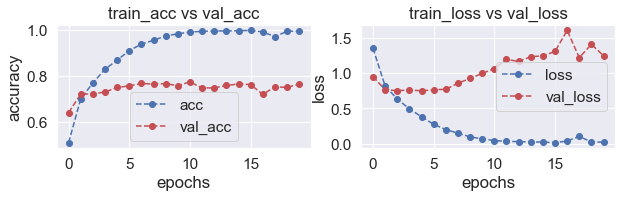

In [21]:
plot_accuracy_loss(history)

In [22]:
test_loss = model.evaluate(test_images, test_labels)


94/94 [==============================] - 1s 10ms/step - loss: 1.1998 - accuracy: 0.7580


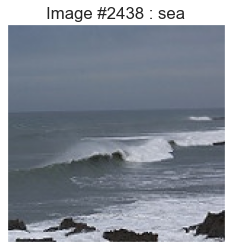

In [23]:
predictions = model.predict(test_images)     # Vector of probabilities
pred_labels = np.argmax(predictions, axis = 1) # We take the highest probability

display_random_image(class_names, test_images, pred_labels)

In [24]:
def print_mislabeled_images(class_names, test_images, test_labels, pred_labels):
    """
        Print 25 examples of mislabeled images by the classifier, e.g when test_labels != pred_labels
    """
    BOO = (test_labels == pred_labels)
    mislabeled_indices = np.where(BOO == 0)
    mislabeled_images = test_images[mislabeled_indices]
    mislabeled_labels = pred_labels[mislabeled_indices]

    title = "Some examples of mislabeled images by the classifier:"
    display_examples(class_names,  mislabeled_images, mislabeled_labels)

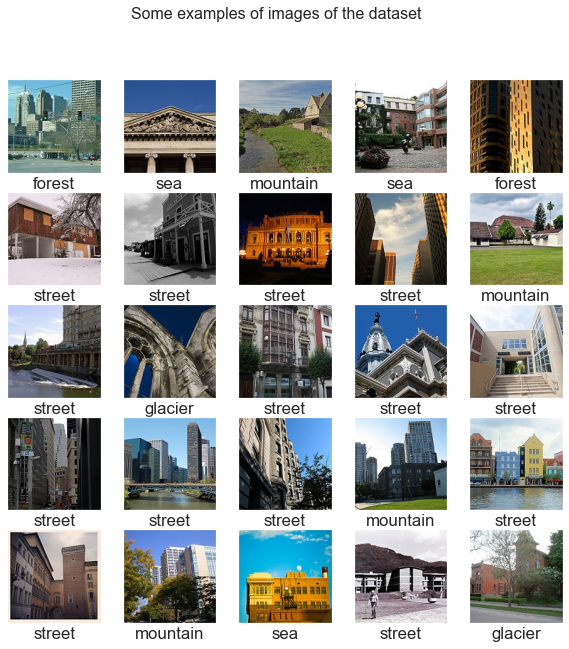

In [25]:
print_mislabeled_images(class_names, test_images, test_labels, pred_labels)

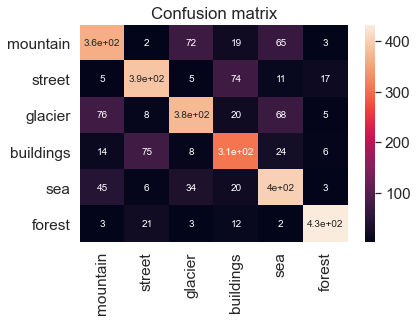

In [26]:
CM = confusion_matrix(test_labels, pred_labels)
ax = plt.axes()
sn.heatmap(CM, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Confusion matrix')
plt.show()

In [27]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input

model = VGG16(weights='imagenet', include_top=False)

58892288/58889256 [==============================] - 1s 0us/step


In [28]:
train_features = model.predict(train_images)
test_features = model.predict(test_images)

In [29]:
n_train, x, y, z = train_features.shape
n_test, x, y, z = test_features.shape
numFeatures = x * y * z

In [30]:
from sklearn import decomposition

pca = decomposition.PCA(n_components = 2)

X = train_features.reshape((n_train, x*y*z))
pca.fit(X)

C = pca.transform(X) # Représentation des individus dans les nouveaux axe
C1 = C[:,0]
C2 = C[:,1]


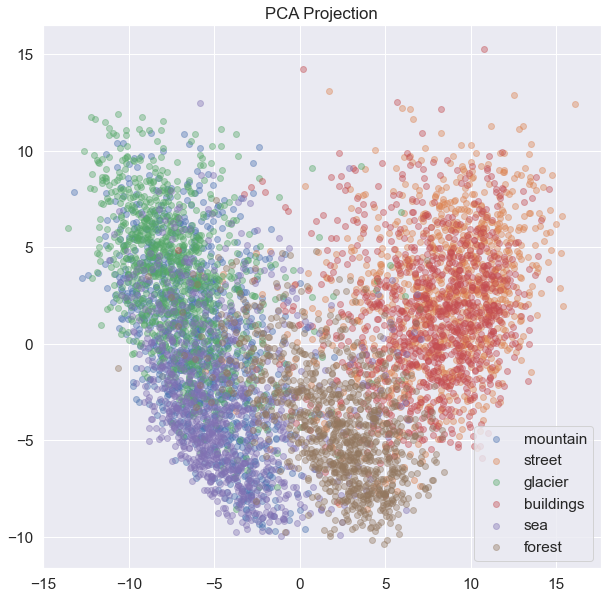

In [31]:
### Figures

plt.subplots(figsize=(10,10))

for i, class_name in enumerate(class_names):
    plt.scatter(C1[train_labels == i][:1000], C2[train_labels == i][:1000], label = class_name, alpha=0.4)
plt.legend()
plt.title("PCA Projection")
plt.show()

In [32]:
model2 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape = (x, y, z)),
    tf.keras.layers.Dense(50, activation=tf.nn.relu),
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
])

model2.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

history2 = model2.fit(train_features, train_labels, batch_size=128, epochs=15, validation_split = 0.2)

Epoch 1/15
88/88 [==============================] - 1s 6ms/step - loss: 0.8118 - accuracy: 0.7043 - val_loss: 0.3537 - val_accuracy: 0.8643
Epoch 2/15
88/88 [==============================] - 0s 5ms/step - loss: 0.3082 - accuracy: 0.8937 - val_loss: 0.3572 - val_accuracy: 0.8632
Epoch 3/15
88/88 [==============================] - 0s 5ms/step - loss: 0.2490 - accuracy: 0.9121 - val_loss: 0.4032 - val_accuracy: 0.8529
Epoch 4/15
88/88 [==============================] - 0s 5ms/step - loss: 0.2003 - accuracy: 0.9283 - val_loss: 0.3124 - val_accuracy: 0.8839
Epoch 5/15
88/88 [==============================] - 0s 5ms/step - loss: 0.1517 - accuracy: 0.9531 - val_loss: 0.3193 - val_accuracy: 0.8867
Epoch 6/15
88/88 [==============================] - 0s 5ms/step - loss: 0.1381 - accuracy: 0.9545 - val_loss: 0.3150 - val_accuracy: 0.8888
Epoch 7/15
88/88 [==============================] - 0s 5ms/step - loss: 0.1094 - accuracy: 0.9672 - val_loss: 0.3323 - val_accuracy: 0.8828
Epoch 8/15
88/88 [==

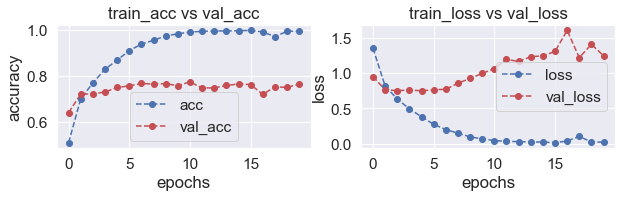

In [33]:
plot_accuracy_loss(history)


In [34]:
test_loss = model2.evaluate(test_features, test_labels)


94/94 [==============================] - 0s 2ms/step - loss: 0.4842 - accuracy: 0.8653


In [35]:
np.random.seed(seed=1997)
# Number of estimators
n_estimators = 10
# Proporition of samples to use to train each training
max_samples = 0.8

max_samples *= n_train
max_samples = int(max_samples)

In [36]:
models = list()
random = np.random.randint(50, 100, size = n_estimators)

for i in range(n_estimators):
    
    # Model
    model = tf.keras.Sequential([ tf.keras.layers.Flatten(input_shape = (x, y, z)),
                                # One layer with random size
                                    tf.keras.layers.Dense(random[i], activation=tf.nn.relu),
                                    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
                                ])
    
    model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])
    
    # Store model
    models.append(model)

In [37]:
histories = []

for i in range(n_estimators):
    # Train each model on a bag of the training data
    train_idx = np.random.choice(len(train_features), size = max_samples)
    histories.append(models[i].fit(train_features[train_idx], train_labels[train_idx], batch_size=128, epochs=10, validation_split = 0.1))

Epoch 1/10
79/79 [==============================] - 1s 6ms/step - loss: 0.7915 - accuracy: 0.6977 - val_loss: 0.3021 - val_accuracy: 0.9012
Epoch 2/10
79/79 [==============================] - 0s 4ms/step - loss: 0.2742 - accuracy: 0.9056 - val_loss: 0.2749 - val_accuracy: 0.8994
Epoch 3/10
79/79 [==============================] - 0s 4ms/step - loss: 0.1949 - accuracy: 0.9378 - val_loss: 0.2040 - val_accuracy: 0.9323
Epoch 4/10
79/79 [==============================] - 0s 4ms/step - loss: 0.1439 - accuracy: 0.9565 - val_loss: 0.1933 - val_accuracy: 0.9394
Epoch 5/10
79/79 [==============================] - 0s 4ms/step - loss: 0.1164 - accuracy: 0.9666 - val_loss: 0.1985 - val_accuracy: 0.9350
Epoch 6/10
79/79 [==============================] - 0s 5ms/step - loss: 0.0882 - accuracy: 0.9795 - val_loss: 0.1730 - val_accuracy: 0.9492
Epoch 7/10
79/79 [==============================] - 0s 4ms/step - loss: 0.0822 - accuracy: 0.9764 - val_loss: 0.2108 - val_accuracy: 0.9288
Epoch 8/10
79/79 [==

79/79 [==============================] - 0s 5ms/step - loss: 0.0365 - accuracy: 0.9922 - val_loss: 0.2509 - val_accuracy: 0.9261
Epoch 10/10
79/79 [==============================] - 0s 4ms/step - loss: 0.0259 - accuracy: 0.9955 - val_loss: 0.2546 - val_accuracy: 0.9252
Epoch 1/10
79/79 [==============================] - 1s 6ms/step - loss: 0.8584 - accuracy: 0.6623 - val_loss: 0.3528 - val_accuracy: 0.8691
Epoch 2/10
79/79 [==============================] - 0s 5ms/step - loss: 0.2945 - accuracy: 0.8959 - val_loss: 0.2726 - val_accuracy: 0.9083
Epoch 3/10
79/79 [==============================] - 0s 4ms/step - loss: 0.2010 - accuracy: 0.9363 - val_loss: 0.2330 - val_accuracy: 0.9207
Epoch 4/10
79/79 [==============================] - 0s 4ms/step - loss: 0.1540 - accuracy: 0.9527 - val_loss: 0.2078 - val_accuracy: 0.9279
Epoch 5/10
79/79 [==============================] - 0s 5ms/step - loss: 0.1231 - accuracy: 0.9631 - val_loss: 0.2249 - val_accuracy: 0.9207
Epoch 6/10
79/79 [============

In [38]:
predictions = []
for i in range(n_estimators):
    predictions.append(models[i].predict(test_features))
    
predictions = np.array(predictions)
predictions = predictions.sum(axis = 0)
pred_labels = predictions.argmax(axis=1)

In [39]:
from sklearn.metrics import accuracy_score
print("Accuracy : {}".format(accuracy_score(test_labels, pred_labels)))

Accuracy : 0.8886666666666667


In [40]:
from keras.models import Model

model = VGG16(weights='imagenet', include_top=False)
model = Model(inputs=model.inputs, outputs=model.layers[-5].output)

In [41]:
train_features = model.predict(train_images)
test_features = model.predict(test_images)

In [42]:
from keras.layers import Input, Dense, Conv2D, Activation , MaxPooling2D, Flatten

model2 = VGG16(weights='imagenet', include_top=False)

input_shape = model2.layers[-4].get_input_shape_at(0) # get the input shape of desired layer
layer_input = Input(shape = (9, 9, 512)) # a new input tensor to be able to feed the desired layer
# https://stackoverflow.com/questions/52800025/keras-give-input-to-intermediate-layer-and-get-final-output

x = layer_input
for layer in model2.layers[-4::1]:
    x = layer(x)
    
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)
x = Dense(100,activation='relu')(x)
x = Dense(6,activation='softmax')(x)

# create the model
new_model = Model(layer_input, x)

In [43]:
new_model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [44]:
new_model.summary()


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 9, 9, 512)]       0         
_________________________________________________________________
block5_conv1 (Conv2D)        multiple                  2359808   
_________________________________________________________________
block5_conv2 (Conv2D)        multiple                  2359808   
_________________________________________________________________
block5_conv3 (Conv2D)        multiple                  2359808   
_________________________________________________________________
block5_pool (MaxPooling2D)   multiple                  0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 2, 2, 64)          294976    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 1, 64)          0   

In [45]:
history = new_model.fit(train_features, train_labels, batch_size=128, epochs=10, validation_split = 0.2)


Epoch 1/10
88/88 [==============================] - 7s 71ms/step - loss: 1.0369 - accuracy: 0.5902 - val_loss: 0.3718 - val_accuracy: 0.8717
Epoch 2/10
88/88 [==============================] - 5s 62ms/step - loss: 0.3327 - accuracy: 0.8785 - val_loss: 0.3088 - val_accuracy: 0.8874
Epoch 3/10
88/88 [==============================] - 5s 62ms/step - loss: 0.2823 - accuracy: 0.9002 - val_loss: 0.2609 - val_accuracy: 0.9099
Epoch 4/10
88/88 [==============================] - 5s 62ms/step - loss: 0.2124 - accuracy: 0.9268 - val_loss: 0.2824 - val_accuracy: 0.8995
Epoch 5/10
88/88 [==============================] - 5s 62ms/step - loss: 0.1820 - accuracy: 0.9373 - val_loss: 0.2675 - val_accuracy: 0.9067
Epoch 6/10
88/88 [==============================] - 6s 63ms/step - loss: 0.1480 - accuracy: 0.9475 - val_loss: 0.3449 - val_accuracy: 0.9006
Epoch 7/10
88/88 [==============================] - 6s 63ms/step - loss: 0.1139 - accuracy: 0.9598 - val_loss: 0.3468 - val_accuracy: 0.8985
Epoch 8/10
88

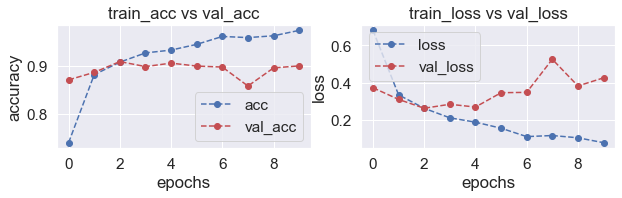

In [46]:
plot_accuracy_loss(history)

In [47]:
from sklearn.metrics import accuracy_score

predictions = new_model.predict(test_features)    
pred_labels = np.argmax(predictions, axis = 1)
print("Accuracy : {}".format(accuracy_score(test_labels, pred_labels)))

Accuracy : 0.8973333333333333
